## Estudo de critérios de transição de sigmoides para modelagem matemática de múltiplas ondas epidemiológicas

Testando diferentes filtros

Importando bibliotecas e módulos implementados

In [1]:
# External libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Implemented modules
import optimize_tg
# Obs: modified version of the new_wave module
import new_wave_filt
from new_wave_filt import get_transition_points

Carregando dados

In [2]:
# Import data
data = pd.read_csv("../Datasets/tokyo.csv") 
city_name = 'Osaka' 
indicator='cases'

In [3]:
if(indicator == 'deaths'):
    #deaths
    acc_data = data.cumulative_deceased
else:
    # cases
    #acc_data = data.total_confirmed
    acc_data = data.cumulative_confirmed #(Japan)

normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(0, len(acc_data)-1, len(acc_data))

normalized_acc_data = normalized_acc_data.tolist()

if(indicator == 'deaths'):
    daily_data = data.new_deceased
else:
    daily_data = data.new_confirmed


scaling_factor = 500
acc_data = acc_data / scaling_factor
daily_data = list(daily_data/ scaling_factor)

Definindo condições iniciais de cada sigmoide no modelo

In [17]:
# Initial Conditions

def initial_cond_0(y_t):
    #A0 = 100
    A0 = 2*max(y_t)
    tp0 = (2/3)*len(y_t)
    delta0 = (1/4)*len(y_t)
    nu0 = 1
    return [A0, tp0, delta0, nu0]

optimize_tg.initial_cond = initial_cond_0

def update_cond_nw(A0, tp0):
    tp0 += 150 # Obs: ideal distance between sigmois ~ 150 days 
    A0 *= 0.005
    return [A0, tp0]
optimize_tg.update_cond = update_cond_nw

## Testando diferentes filtros

In [18]:
# Moving average filter
def moving_average(x, win_size):
    filtered = np.convolve(x, np.ones(win_size), 'valid') / win_size
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

# Median filter
def median_filter(x, win_size):
    S = 1
    nrows = ((x.size-win_size)//S)+1
    n = x.strides[0]
    strided = np.lib.stride_tricks.as_strided(x, shape=(nrows,win_size), strides=(S*n,n))
    filtered  = np.median(strided,axis=1)
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

def butterworth_lowpass_filter(data, cutoff_freq, fs, order=2):
    #fs is the sampling rate
    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # lfilter apply filter along one dimension
    y = lfilter(b, a, data)
    return y

In [19]:
rel_rmse_by_test = {}
rel_rmse_by_test['Interval'] = ['Wave 1', 'Waves 1 to 2', 'Waves 1 to 3', 'Waves 1 to 4', 'Waves 1 to 5']

### 1 - Filtros padrão

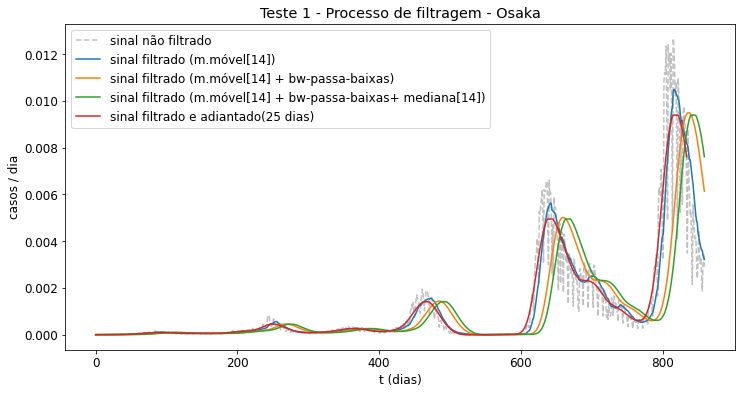

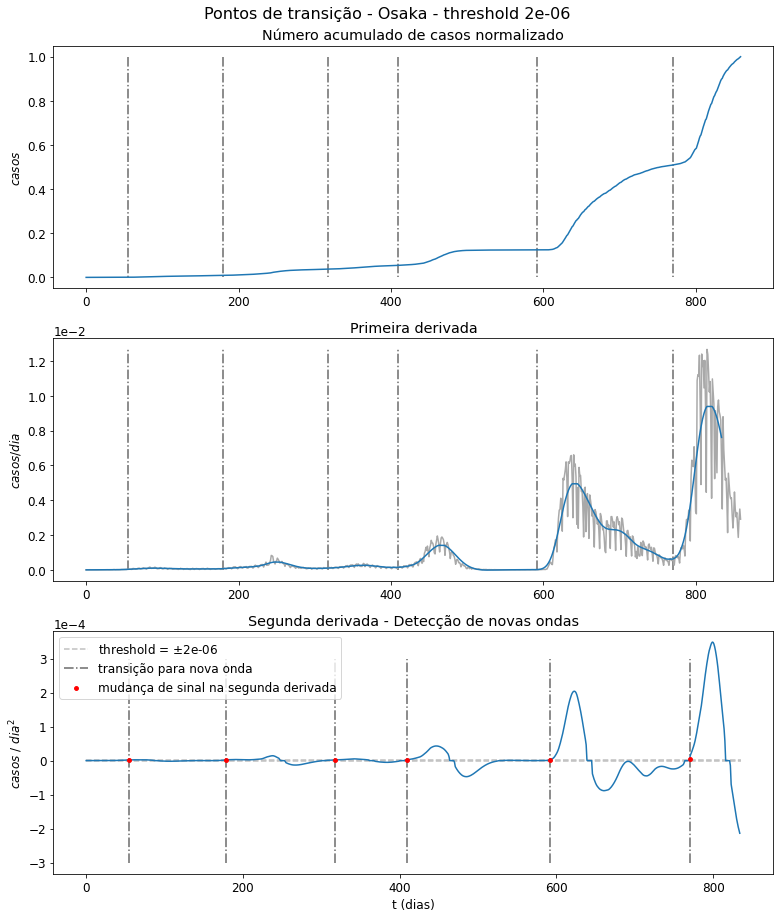

x_nw: [179, 318, 409, 592, 770]
Sigmoid #1 - A0:50.78212737160569 | tp0:103.28125437933235 | delta0:22.234902323785068 | nu0:1.0 
(optimal) Sigmoid #1 - A0:50.78212737160569 | tp0:103.28125437933235 | delta0:22.234902323785068 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #2 - A0:166.9535518404755 | tp0:245.27705740588917 | delta0:16.649594851147377 | nu0:1.0 
(optimal) Sigmoid #2 - A0:166.9535518404755 | tp0:245.27705740588917 | delta0:16.649594851147377 | nu0:1.0 
Sigmoid #3 - A0:110.66816115491378 | tp0:360.57583280554934 | delta0:16.009527840410605 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #3 - A0:110.66816115491378 | tp0:360.57583280554934 | delta0:16.009527840410605 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #4 - A0:407.5274800750693 | tp0:462.1836056188735 | delta0:10.31511405845775 | nu0:1.0 
(optimal) Sigmoid #4 - A0:407.5274800750693 | tp0:462.1836056188735 | delta0:10.31511405845775 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #5 - A0:2223.7030899299975 | tp0:660.5249785595787 | delta0:20.534006629539753 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))


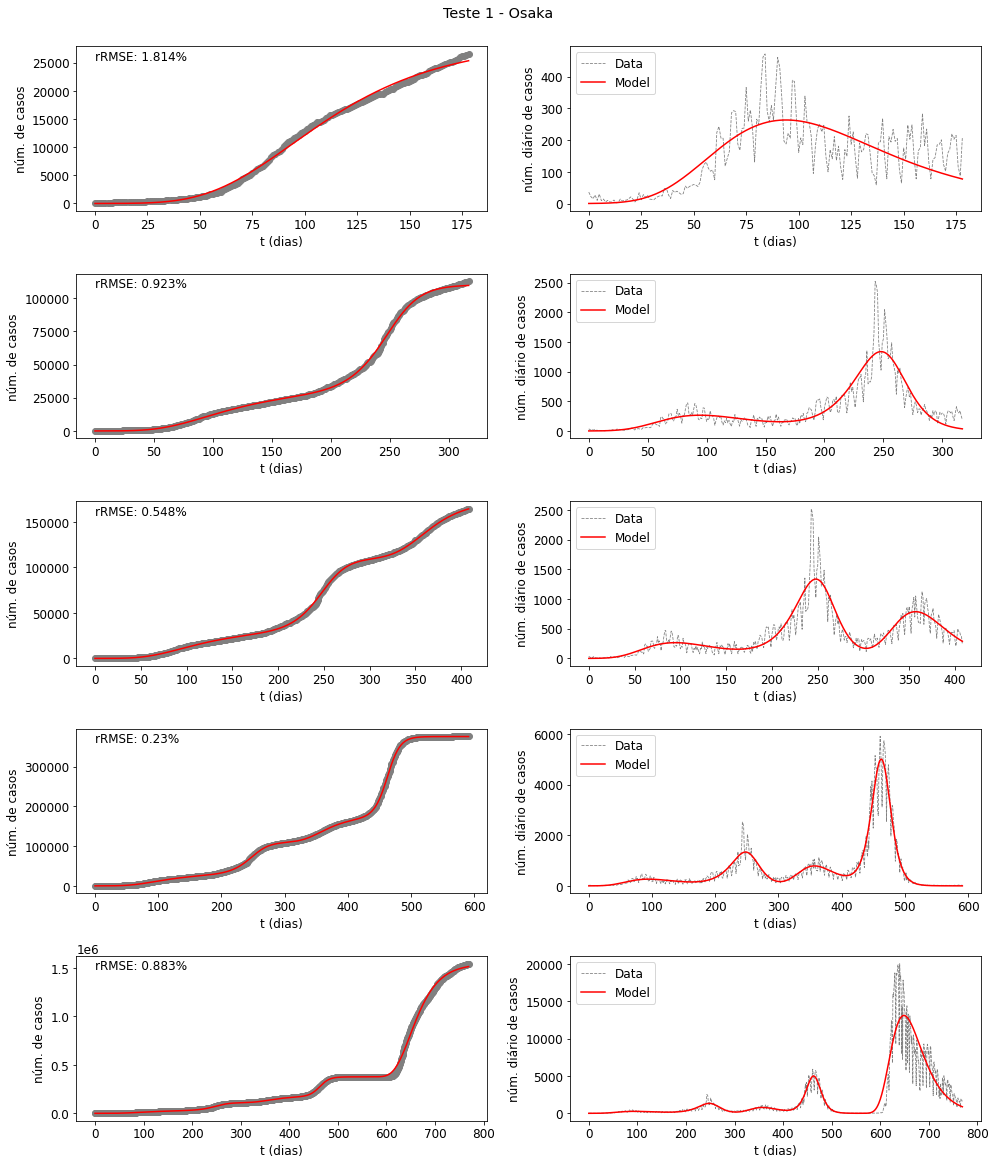

In [20]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Teste 1 - Processo de filtragem - {city_name}")
    plt.xlabel("t (dias)")
    plt.ylabel("casos / dia")

    # Plotting unfiltered version
    plt.plot(data, label="sinal não filtrado", c='silver', linestyle='dashed')

    # Moving average with 14-day window
    filtered_data = moving_average(data, 14)
    plt.plot(filtered_data, label="sinal filtrado (m.móvel[14])")
    
    # 2nd Order Low-Pass Filter with 14-day window
    order = 2
    fs = len(data) # sampling rate       
    cutoff = 14 # cutoff freq.
    filtered_data =  butterworth_lowpass_filter(filtered_data, cutoff, fs, order)
    plt.plot(filtered_data, label="sinal filtrado (m.móvel[14] + bw-passa-baixas)")

    # Median filter with 14-day window
    filtered_data = median_filter(filtered_data, 14)
    plt.plot(filtered_data, label="sinal filtrado (m.móvel[14] + bw-passa-baixas+ mediana[14])")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 25 days
    n_days_shift = 25
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"sinal filtrado e adiantado({n_days_shift} dias)")

    plt.legend()

    plt.savefig(f'Figuras/TG_filtering_process_{city_name}.png', dpi=600)
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, city_name=city_name, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize_tg.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 1'] = rel_rmse_list

### 2 - Só média móvel

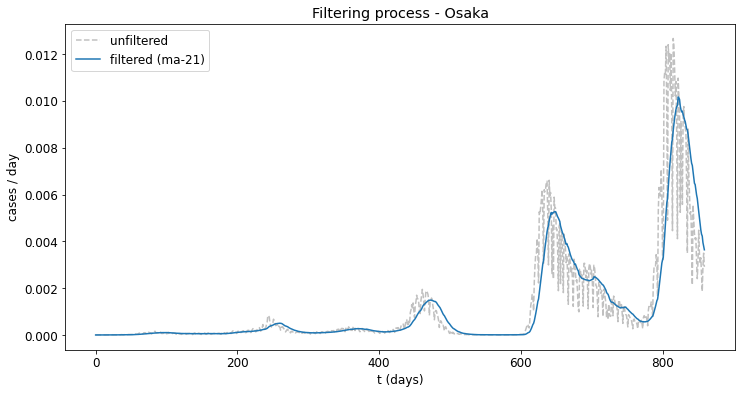

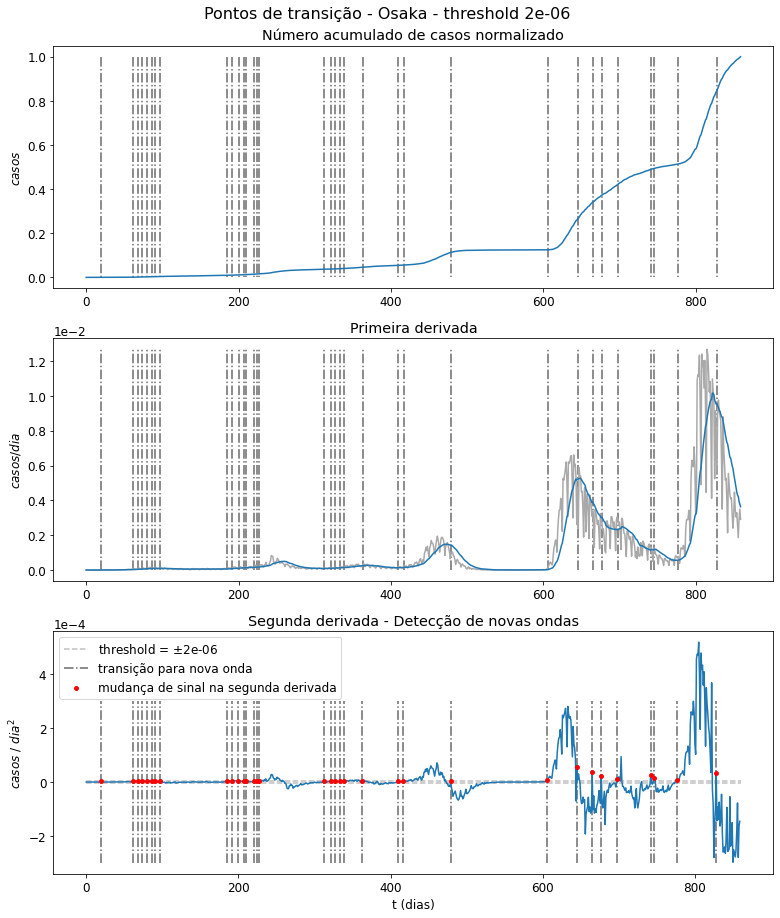

x_nw: [61, 68, 73, 80, 86]
Sigmoid #1 - A0:183.8562226046499 | tp0:132.02093824913788 | delta0:19.09214757082101 | nu0:1.0 
(optimal) Sigmoid #1 - A0:183.8562226046499 | tp0:132.02093824913788 | delta0:19.09214757082101 | nu0:1.0 
Sigmoid #2 - A0:0.9192811130232496 | tp0:282.0209382491379 | delta0:19.09214757082101 | nu0:1.0 
(optimal) Sigmoid #2 - A0:0.9192811130232496 | tp0:282.0209382491379 | delta0:19.09214757082101 | nu0:1.0 
Sigmoid #3 - A0:0.004596405565116248 | tp0:432.0209382491379 | delta0:19.09214757082101 | nu0:1.0 
(optimal) Sigmoid #3 - A0:0.004596405565116248 | tp0:432.0209382491379 | delta0:19.09214757082101 | nu0:1.0 
Sigmoid #4 - A0:2.298202782558124e-05 | tp0:582.0209382491379 | delta0:19.09214757082101 | nu0:1.0 
(optimal) Sigmoid #4 - A0:2.298202782558124e-05 | tp0:582.0209382491379 | delta0:19.09214757082101 | nu0:1.0 
Sigmoid #5 - A0:1.149101391279062e-07 | tp0:732.0209382491379 | delta0:19.09214757082101 | nu0:1.0 


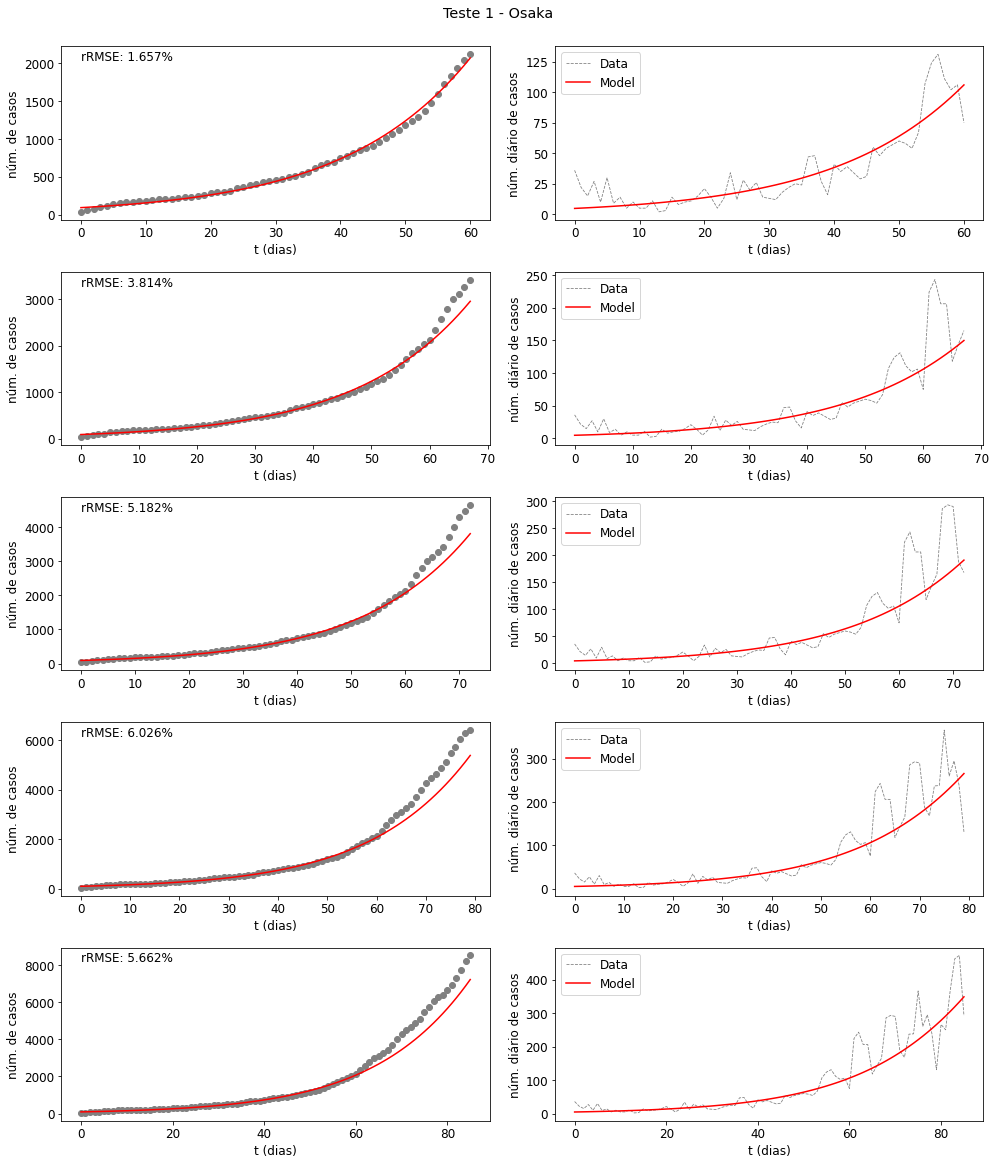

In [21]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # Moving average with 21-day window
    filtered_data = moving_average(data, 21)
    plt.plot(filtered_data, label="filtered (ma-21)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, city_name=city_name, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize_tg.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 2'] = rel_rmse_list

### 3 - Só filtro butterworth + avanço do sinal

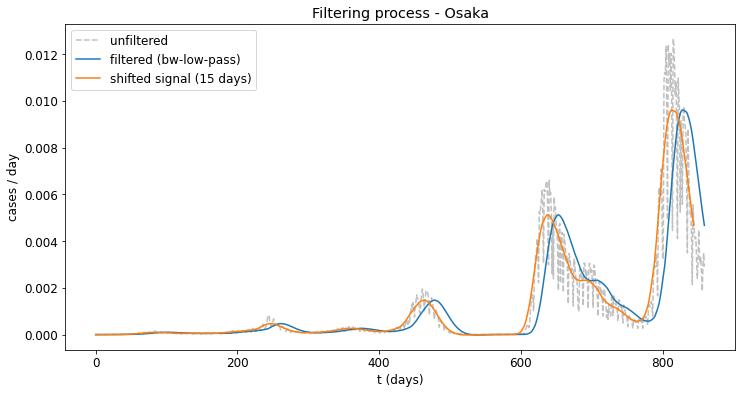

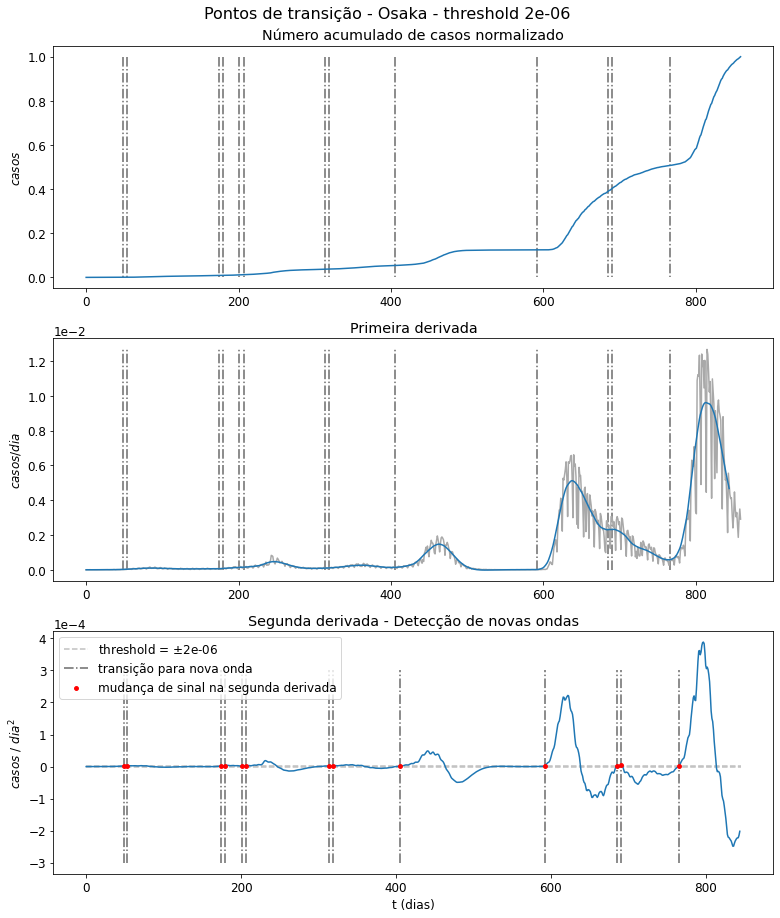

x_nw: [53, 174, 179, 201, 207]
Sigmoid #1 - A0:16.249434445274915 | tp0:84.09555737780579 | delta0:19.162016599718743 | nu0:1.0 
(optimal) Sigmoid #1 - A0:16.249434445274915 | tp0:84.09555737780579 | delta0:19.162016599718743 | nu0:1.0 
Sigmoid #2 - A0:34.46409328097516 | tp0:112.79639635197816 | delta0:22.128608486853487 | nu0:1.0 
(optimal) Sigmoid #2 - A0:34.46409328097516 | tp0:112.79639635197816 | delta0:22.128608486853487 | nu0:1.0 
Sigmoid #3 - A0:3120.9445663368692 | tp0:228.02491511440715 | delta0:7.401904651219517 | nu0:1.0 
(optimal) Sigmoid #3 - A0:3120.9445663368692 | tp0:228.02491511440715 | delta0:7.401904651219517 | nu0:1.0 
Sigmoid #4 - A0:15.604722831684347 | tp0:378.0249151144071 | delta0:7.401904651219517 | nu0:1.0 
(optimal) Sigmoid #4 - A0:15.604722831684347 | tp0:378.0249151144071 | delta0:7.401904651219517 | nu0:1.0 
Sigmoid #5 - A0:0.07802361415842174 | tp0:528.0249151144071 | delta0:7.401904651219517 | nu0:1.0 


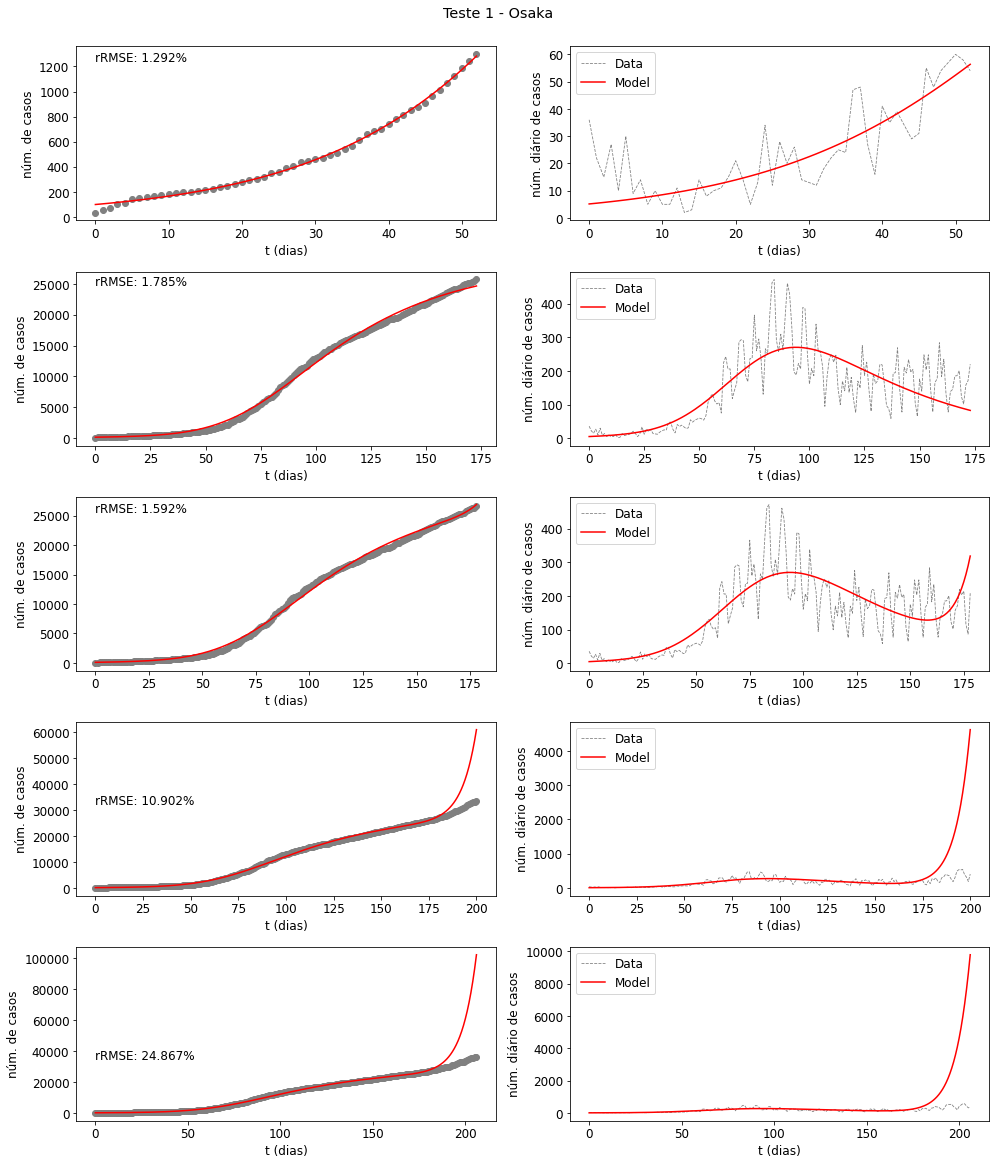

In [22]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # 2nd Order Low-Pass Filter with 14-day window
    order = 2
    fs = len(data) # sampling rate       
    cutoff = 14 # cutoff freq.
    filtered_data =  butterworth_lowpass_filter(data, cutoff, fs, order)
    plt.plot(filtered_data, label="filtered (bw-low-pass)")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 15 days
    n_days_shift = 15
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"shifted signal ({n_days_shift} days)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, city_name=city_name, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize_tg.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 3'] = rel_rmse_list

### 4 - Só mediana + avanço

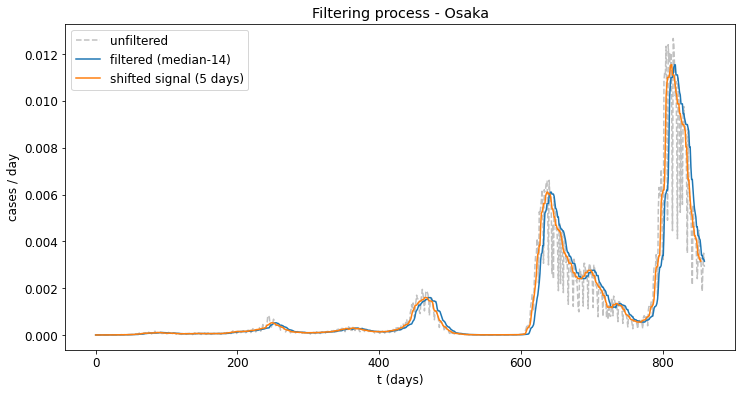

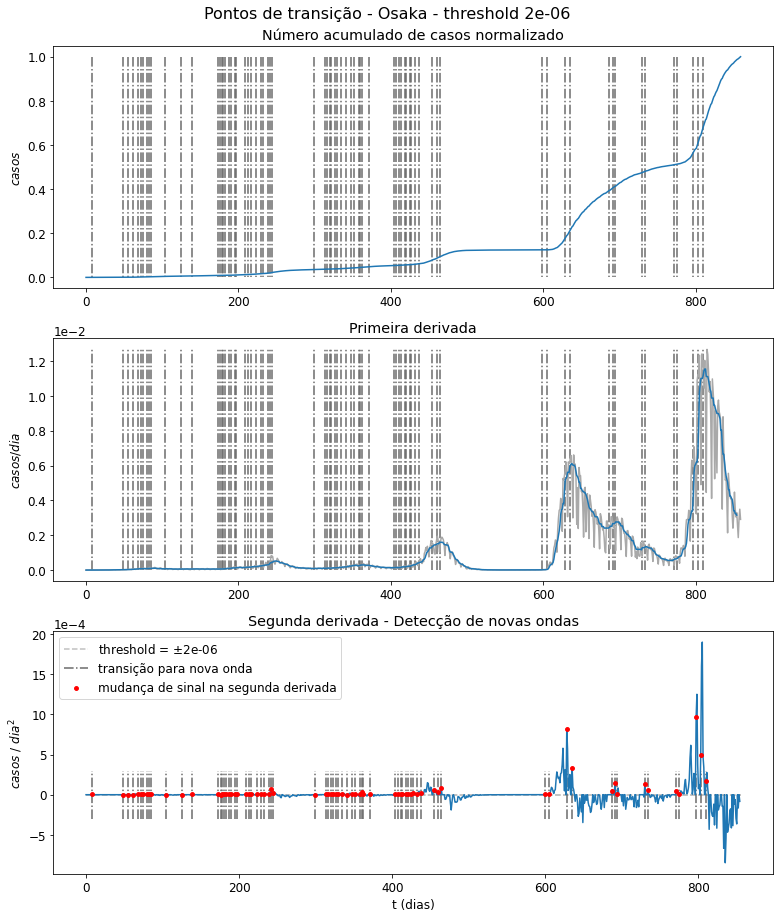

x_nw: [48, 55, 61, 68, 72]
Sigmoid #1 - A0:2.3156526725640596 | tp0:32.97253434963098 | delta0:11.243767469952266 | nu0:1.0 
(optimal) Sigmoid #1 - A0:2.3156526725640596 | tp0:32.97253434963098 | delta0:11.243767469952266 | nu0:1.0 
Sigmoid #2 - A0:0.011578263362820298 | tp0:182.972534349631 | delta0:11.243767469952266 | nu0:1.0 
(optimal) Sigmoid #2 - A0:0.011578263362820298 | tp0:182.972534349631 | delta0:11.243767469952266 | nu0:1.0 
Sigmoid #3 - A0:5.7891316814101495e-05 | tp0:332.972534349631 | delta0:11.243767469952266 | nu0:1.0 
(optimal) Sigmoid #3 - A0:5.7891316814101495e-05 | tp0:332.972534349631 | delta0:11.243767469952266 | nu0:1.0 
Sigmoid #4 - A0:2.894565840705075e-07 | tp0:482.972534349631 | delta0:11.243767469952266 | nu0:1.0 
(optimal) Sigmoid #4 - A0:2.894565840705075e-07 | tp0:482.972534349631 | delta0:11.243767469952266 | nu0:1.0 
Sigmoid #5 - A0:1.4472829203525375e-09 | tp0:632.972534349631 | delta0:11.243767469952266 | nu0:1.0 


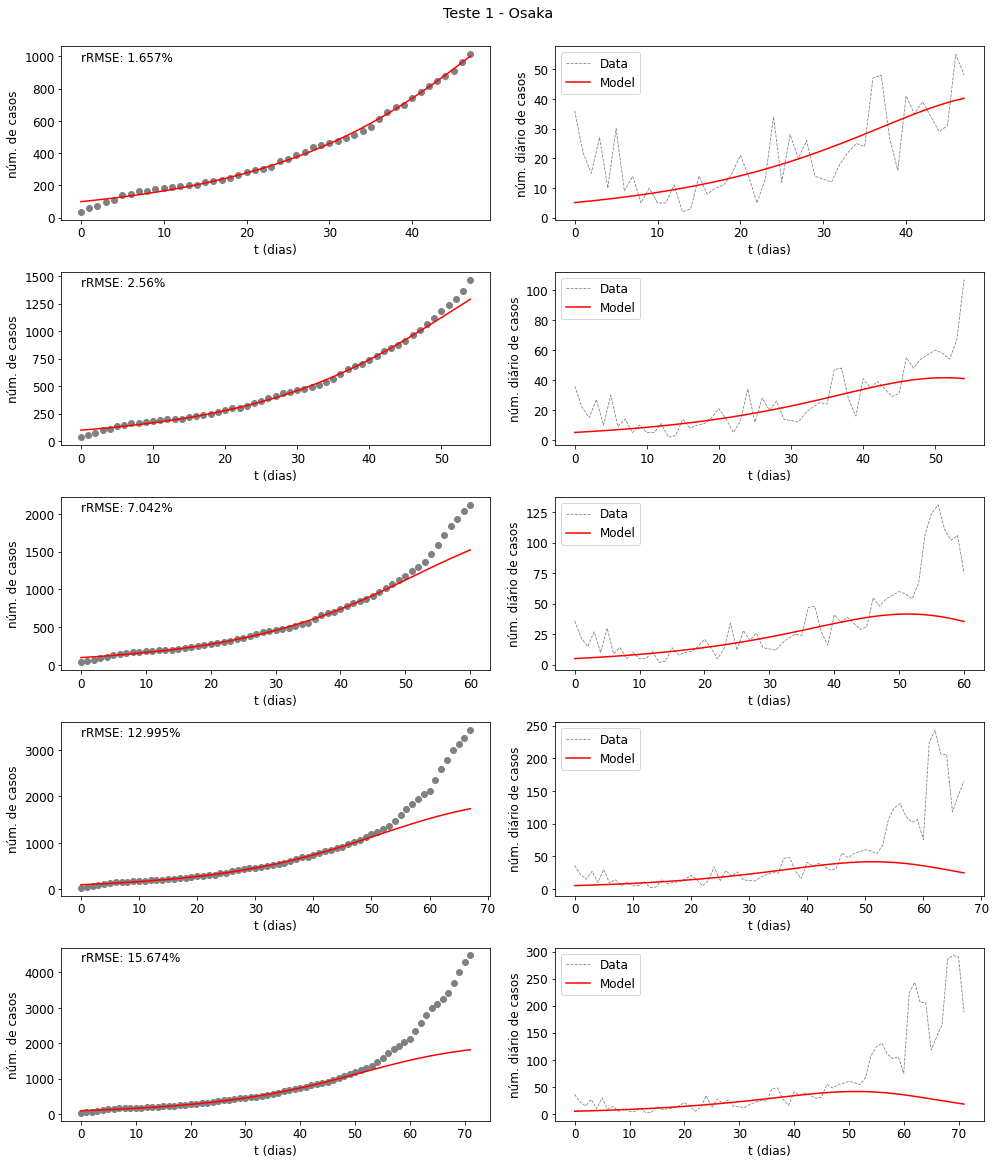

In [23]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # Median filter with 14-day window
    filtered_data = median_filter(data, 14)
    plt.plot(filtered_data, label="filtered (median-14)")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 5 days
    n_days_shift = 5
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"shifted signal ({n_days_shift} days)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, city_name=city_name, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize_tg.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 4'] = rel_rmse_list

### 5 - Média móvel + Mediana + avanço

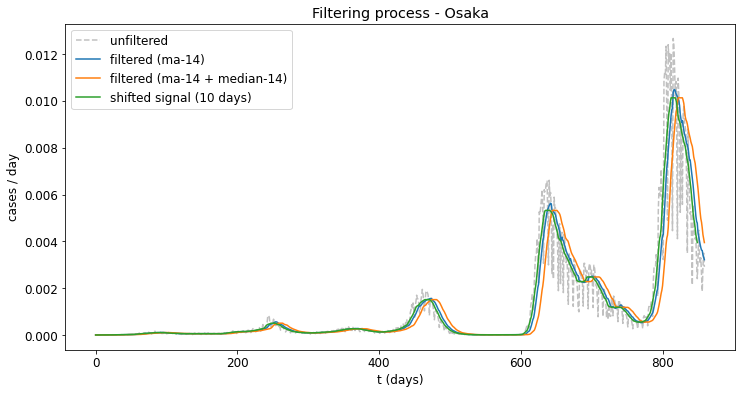

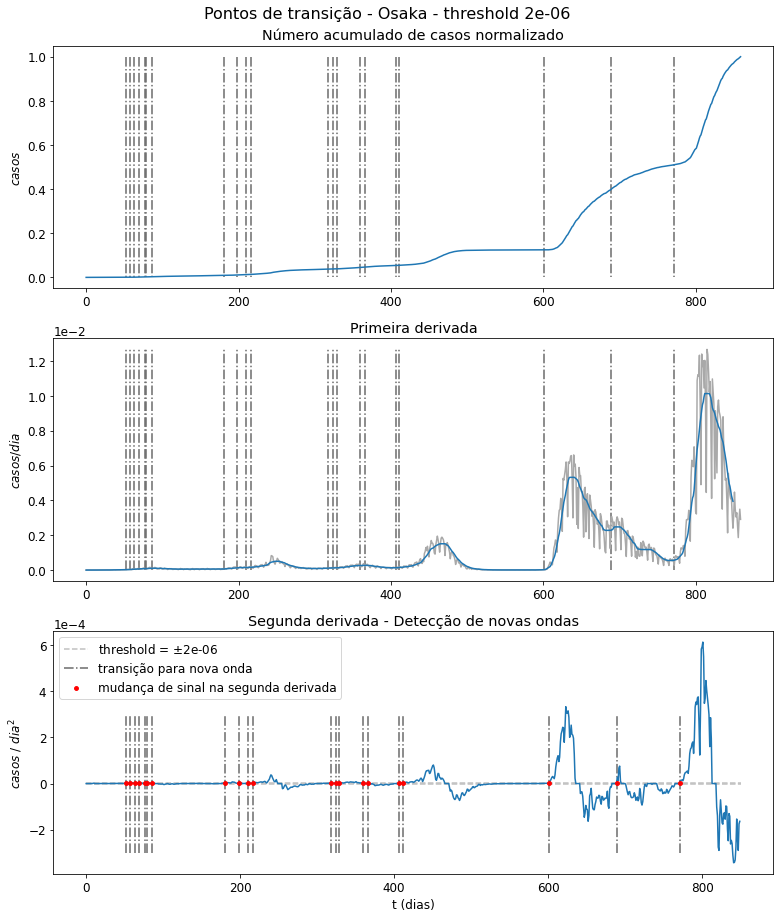

x_nw: [57, 63, 69, 77, 79]
Sigmoid #1 - A0:108.45036422693465 | tp0:125.32297358307092 | delta0:19.909730913229954 | nu0:1.0 
(optimal) Sigmoid #1 - A0:108.45036422693465 | tp0:125.32297358307092 | delta0:19.909730913229954 | nu0:1.0 
Sigmoid #2 - A0:0.5422518211346733 | tp0:275.3229735830709 | delta0:19.909730913229954 | nu0:1.0 
(optimal) Sigmoid #2 - A0:0.5422518211346733 | tp0:275.3229735830709 | delta0:19.909730913229954 | nu0:1.0 
Sigmoid #3 - A0:0.0027112591056733665 | tp0:425.3229735830709 | delta0:19.909730913229954 | nu0:1.0 
(optimal) Sigmoid #3 - A0:0.0027112591056733665 | tp0:425.3229735830709 | delta0:19.909730913229954 | nu0:1.0 
Sigmoid #4 - A0:1.3556295528366832e-05 | tp0:575.322973583071 | delta0:19.909730913229954 | nu0:1.0 
(optimal) Sigmoid #4 - A0:1.3556295528366832e-05 | tp0:575.322973583071 | delta0:19.909730913229954 | nu0:1.0 
Sigmoid #5 - A0:6.778147764183416e-08 | tp0:725.322973583071 | delta0:19.909730913229954 | nu0:1.0 


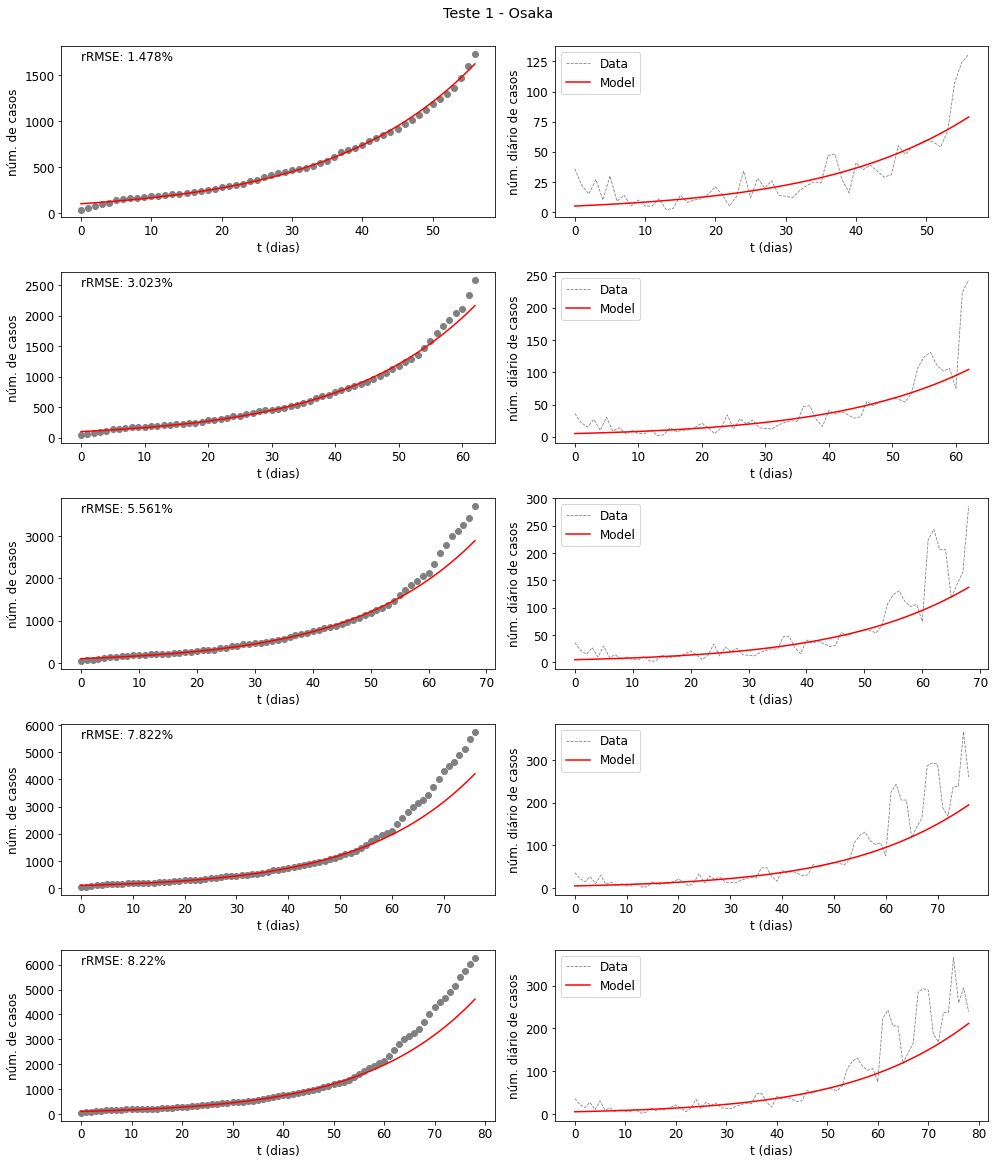

In [24]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # Moving average with 14-day window
    filtered_data = moving_average(data, 14)
    plt.plot(filtered_data, label="filtered (ma-14)")
    # Median filter with 14-day window
    filtered_data = median_filter(filtered_data, 14)
    plt.plot(filtered_data, label="filtered (ma-14 + median-14)")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 25 days
    n_days_shift = 10
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"shifted signal ({n_days_shift} days)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, city_name=city_name, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize_tg.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 5'] = rel_rmse_list

### Bônus - Experimentando frequência de corte do Butterworth
Teste antigo que fiz, mas agora com dados do Japão

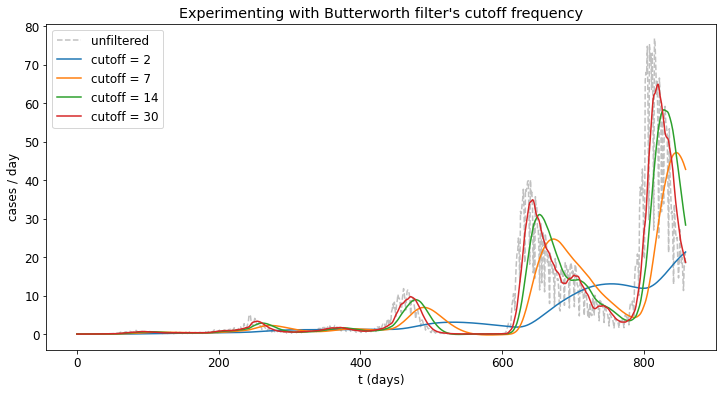

In [25]:
plt.figure(figsize=(12,6))
plt.title("Experimenting with Butterworth filter's cutoff frequency")
plt.xlabel("t (days)")
plt.ylabel("cases / day")

unf_daily_n_cases = daily_data

plt.plot(unf_daily_n_cases, label="unfiltered", c='silver', linestyle='dashed')

order = 2
fs = len(data) # sampling rate       

cutoff = 2 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 7 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 14 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 30 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

plt.legend()
plt.show()


### Resumo dos resultados

- Teste 1 - Filtragem padrão _(ma-14 + bw-low-pass + median-14 + shift-25)_

- Teste 2 - Apenas filtro de média móvel _(ma-21)_

- Teste 3 - Apenas filtro passa baixas Butterworth _(bw-low-pass + shift-15)_

- Teste 4 - Apenas filtro de mediana _(median-14 + shift-5)_
    
- Teste 5 - Média móvel + Mediana _(ma-14 + median-14 + shift-10)_

In [26]:
pd.DataFrame(rel_rmse_by_test)

,Interval,Test 1,Test 2,Test 3,Test 4,Test 5
0,Wave 1,1.814%,1.657%,1.292%,1.657%,1.478%
1,Waves 1 to 2,0.923%,3.814%,1.785%,2.56%,3.023%
2,Waves 1 to 3,0.548%,5.182%,1.592%,7.042%,5.561%
3,Waves 1 to 4,0.23%,6.026%,10.902%,12.995%,7.822%
4,Waves 1 to 5,0.883%,5.662%,24.867%,15.674%,8.22%


Teste 3, que aplica apenas o filtro Butterworth passa baixas, apresentou os menores valores de rRMSE.